# ParikhSamuolisReclassificationNN Final Project File 2
## date last modified: Dec 4, 2024
### how to link to github --> https://saturncloud.io/blog/how-to-add-jupyter-notebook-to-github/

# Loading images and necessary functions - run each time

In [37]:
import os
from PIL import Image
import numpy as np
import random
import shutil

In [38]:
# define directories for train and validation sets
root_dir = '/projectnb/ds340/projects/Samuolis_Parikh_Image_Data/'

train_dir = root_dir +"resized_images/train"
validation_dir = root_dir + "resized_images/validation"

train_target = train_dir +"/baldeagle"
train_nontarget = train_dir +"/nonbaldeagle"

val_target = validation_dir +"/baldeagle"
val_nontarget = validation_dir +"/nonbaldeagle"

In [39]:
def load_images_from_folders(folder1, folder2, img_size = (224,224)):
    images = []
    labels = []
    
    # load images from the first folder
    for filename in os.listdir(folder1):
        img_path = os.path.join(folder1, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))  # convert image to array
                labels.append(1)  # class label for folder1
        except Exception as e:
            print(f"Could not load image {filename} from {folder1}: {e}")

    # load images from the second folder
    for filename in os.listdir(folder2):
        img_path = os.path.join(folder2, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(0)  # class label for folder2
        except Exception as e:
            print(f"Could not load image {filename} from {folder2}: {e}")

    # convert lists to NumPy arrays
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

images_train, label_train = load_images_from_folders(train_target, train_nontarget)
images_val, label_val = load_images_from_folders(val_target, val_nontarget)

In [40]:
## for debugging:
print(images_train.shape, label_train.shape, type(images_train))
print(images_train.min(), images_train.max())  # expected: 0 255, later will normalize
print(f"Initial eagle count: {np.sum(label_train == 1)}")
print(f"Initial noneagle count: {np.sum(label_train == 0)}")

(5200, 224, 224, 3) (5200,) <class 'numpy.ndarray'>
0 255
Initial eagle count: 1300
Initial noneagle count: 3900


In [41]:
def change_labels(labels, percentage):
    random.seed(340)
    label_one_indices = np.where(labels == 1)[0]
    
    n = int(len(label_one_indices) * (percentage / 100))
    
    indices_to_change = np.random.choice(label_one_indices, size=n, replace=False)
    
    labels[indices_to_change] = 0
    
    return labels, indices_to_change

# for example, change 20% of label 1s to label 0
percentage = 0  
# changed_indices
# label_train, changed_indices = change_labels(label_train, percentage)

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.utils.set_random_seed(340)
tf.config.experimental.enable_op_determinism()

In [43]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
epochs = 15
# restore best weights make the model be the one that was the best instead of last one
# patience changed from 4-->3

In [44]:
# reload images
images_train, label_train = load_images_from_folders(train_target, train_nontarget)
percentage = 20  
# changed_indices
label_train, changed_indices = change_labels(label_train, percentage)

In [45]:
print(f"New eagle count: {np.sum(label_train == 1)}")
print(f"New noneagle count: {np.sum(label_train == 0)}")

New eagle count: 1040
New noneagle count: 4160


In [46]:
from tensorflow.keras.layers import Input, Dropout, Concatenate
confidence_init = confidence_init = np.array([.35 if x<.5 else 1 for x in label_train]).reshape(5200,1)
# start with all 1s for confidence
# this doesn't work --- we don't know before hand which indices we aren't confident about, we especially don't know 
# to specifically be less confident for the labels that we changed
# confidence_init[label_train == 0] = 0  # Set confidence to 0 for original 0 labels
# confidence_init[changed_indices] = 0.35  # Set confidence to 0.35 for flipped labels
# confidence_init = confidence_init.reshape(-1, 1)  # Reshape to (N, 1)

# print data statistics
print(f"New eagle count: {np.sum(label_train == 1)}")
print(f"New noneagle count: {np.sum(label_train == 0)}")
print(f"Confidence values: {confidence_init[:10].flatten()}")

New eagle count: 1040
New noneagle count: 4160
Confidence values: [0.35 1.   1.   1.   1.   1.   1.   0.35 1.   1.  ]


In [47]:
# remake models
# mutliple inputs taken from chat and https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# we have full confidence if it is a 1, the lower the number the more confident you are in the 0 class -- .999999 vs .00004


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True


# add new fully connected layers for binary classification
image_input = base_model.input
x = base_model.output
x = Flatten()(x)

additional_input = Input(shape=(1,), name="additional_input") # shape is just 1 feature for the confidence 
y = Dense(64, activation='relu')(additional_input) 
y = Dropout(0.1)(y) # when .5, the additional input was too powerful, the prediction vals were always either to close to 1 or 0, we try to make the additional input less important than the images

combined = Concatenate()([x, y]) # 2 channels
combined = Dense(256, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)  # sigmoid for binary 

model = Model(inputs=[image_input, additional_input], outputs=combined)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

# Playing around with different parameters to get the best combination
### n_percentage = [5, 10, 15, 20]
### max_iterations = [5, 10, 15]
### n_percent = [5, 10, 15, 20]

In [33]:
# has no relevance to the code - just leaving here for our future reference to how we indexed into our lists
data_array = np.array([0, 1, 0, 3, 0, 5])  # The array containing 0s and other values
index_array = np.array([0, 1, 2, 3, 4, 5])  # The array of indices

# filter the index_array where the corresponding value in data_array is not 0
filtered_indices = index_array[data_array[index_array] != 0]

print("Filtered Indices:", filtered_indices[2])

Filtered Indices: 5


In [41]:
n_percentage = 5  # % of least confident eagle predictions to adjust
max_iterations = 10 # has biggest numbers from above output  
convergence_tolerance = 0  # stop if change ratio is this
high_conf_threshold = 0.8  # threshold for confident eagle flips
confidence_init = confidence_init = np.array([.35 if x<.5 else 1 for x in label_train]).reshape(5200,1)

num_incorrectly_modified = 0
num_modified = 0
for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1}...")

    # step 1: train model
    history = model.fit(
        [images_train, confidence_init],
        label_train,
        batch_size=100, # ok this might seem crazy but im wondering if w batch=32 it wasn't encountering enough wrong labels 
        epochs=1,
        # validation_data=([images_val, np.ones((len(images_val), 1))], label_val), # this was a line from chat, replaced w ours instead below
        validation_data=([images_val, label_val.reshape(-1,1)], label_val),
        callbacks=callbacks,
        shuffle = True,
        verbose=0
    )

    # step 2: predict probabilities
    preds = model.predict([images_train, confidence_init]).flatten()

    # step 3: identify least confident eagle predictions
    low_confidence_indices = np.where((label_train == 0) & (preds < 0.5) & (preds != 0))[0] # grabbing indices where label_train is 0 (noneagle), focusing in on the misclassified
    filtered_indices = low_confidence_indices[confidence_init.flatten()[low_confidence_indices]!= 0]
    sorted_indices = filtered_indices[np.argsort(preds[filtered_indices])] # sorts the preds low to high
    to_adjust = sorted_indices[:int(len(sorted_indices) * (n_percentage / 100))] # only grabbing 5% rn of the bottom
    

    # step 4: update confidence for least confident predictions
    if len(to_adjust) > 0:
        confidence_init[to_adjust] = 0  # reduce confidence to 0 for the indices we picked by %
        avg_confidence = np.mean(preds[to_adjust])
        print(f"Adjusted {len(to_adjust)} indices, avg confidence: {avg_confidence:.4f}")
    else:
        print("No indices to adjust in this iteration.")
        
    print(f"Changed Indices: {sorted(to_adjust)}")
    print(f"Predictions for Changed Indices: {preds[to_adjust]}")
    wrongly_switched = [x for x in changed_indices if x in to_adjust]
    print("FOR CHECKING -- THE EAGLES WHICH THE MODEL GOT EVEN MORE CONFIDENT WASN'T EAGLES:", wrongly_switched)
    num_incorrectly_modified += len(wrongly_switched)
    num_modified += len(to_adjust)
    print("Total Number of Eagles the model believes are not eagles", num_incorrectly_modified)
    print("Total Number of images the model believes are not eagles", num_modified)


    # step 5: check for convergence
    if len(to_adjust) > 0:
            change_ratio = len(to_adjust) / len(label_train)  
    else:
            change_ratio=0
    print(f"Change ratio: {change_ratio:.4f}")

    if change_ratio < convergence_tolerance:
        print("Convergence reached.")
        break

Iteration 1...
  5/163 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step 

2024-12-02 21:43:02.746316: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 208 indices, avg confidence: 0.0000
Changed Indices: [np.int64(530), np.int64(578), np.int64(1302), np.int64(1314), np.int64(1329), np.int64(1332), np.int64(1334), np.int64(1371), np.int64(1372), np.int64(1429), np.int64(1440), np.int64(1441), np.int64(1442), np.int64(1446), np.int64(1454), np.int64(1476), np.int64(1484), np.int64(1488), np.int64(1528), np.int64(1534), np.int64(1565), np.int64(1587), np.int64(1594), np.int64(1596), np.int64(1599), np.int64(1622), np.int64(1640), np.int64(1645), np.int64(1660), np.int64(1668), np.int64(1676), np.int64(1682), np.int64(1695), np.int64(1723), np.int64(1785), np.int64(1797), np.int64(1800), np.int64(1821), np.int64(1825), np.int64(1862), np.int64(1873), np.int64(1895), np.int64(1922), np.int64(1927), np.int64(1953), np.int64(1974), np.int64(1977), np.int64(2014), np.int64(2108), np.int64(2119), np.int64(2122), np.int64(2128), np.int64(2144), np.int64(2151), np.int64(2168), np.int64(2173), n

2024-12-02 21:43:35.428100: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 197 indices, avg confidence: 0.0000
Changed Indices: [np.int64(731), np.int64(1307), np.int64(1339), np.int64(1400), np.int64(1463), np.int64(1468), np.int64(1487), np.int64(1502), np.int64(1513), np.int64(1521), np.int64(1545), np.int64(1570), np.int64(1611), np.int64(1623), np.int64(1665), np.int64(1666), np.int64(1681), np.int64(1688), np.int64(1696), np.int64(1711), np.int64(1715), np.int64(1719), np.int64(1768), np.int64(1773), np.int64(1778), np.int64(1780), np.int64(1795), np.int64(1859), np.int64(1897), np.int64(1899), np.int64(1965), np.int64(1971), np.int64(1976), np.int64(1984), np.int64(2061), np.int64(2073), np.int64(2079), np.int64(2083), np.int64(2100), np.int64(2103), np.int64(2114), np.int64(2148), np.int64(2160), np.int64(2229), np.int64(2290), np.int64(2296), np.int64(2299), np.int64(2307), np.int64(2313), np.int64(2327), np.int64(2348), np.int64(2357), np.int64(2389), np.int64(2412), np.int64(2423), np.int64(2446), 

2024-12-02 21:44:07.944383: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 187 indices, avg confidence: 0.0000
Changed Indices: [np.int64(1308), np.int64(1344), np.int64(1376), np.int64(1383), np.int64(1388), np.int64(1418), np.int64(1470), np.int64(1493), np.int64(1552), np.int64(1578), np.int64(1580), np.int64(1609), np.int64(1786), np.int64(1812), np.int64(1817), np.int64(1828), np.int64(1833), np.int64(1835), np.int64(1842), np.int64(1889), np.int64(1905), np.int64(1913), np.int64(1942), np.int64(1954), np.int64(1962), np.int64(1981), np.int64(1982), np.int64(1987), np.int64(1998), np.int64(2002), np.int64(2016), np.int64(2035), np.int64(2038), np.int64(2046), np.int64(2075), np.int64(2094), np.int64(2112), np.int64(2131), np.int64(2133), np.int64(2156), np.int64(2157), np.int64(2161), np.int64(2183), np.int64(2190), np.int64(2359), np.int64(2360), np.int64(2372), np.int64(2380), np.int64(2395), np.int64(2397), np.int64(2422), np.int64(2495), np.int64(2555), np.int64(2557), np.int64(2564), np.int64(2569),

2024-12-02 21:44:40.673121: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 178 indices, avg confidence: 0.0000
Changed Indices: [np.int64(1331), np.int64(1349), np.int64(1387), np.int64(1430), np.int64(1436), np.int64(1518), np.int64(1526), np.int64(1553), np.int64(1607), np.int64(1619), np.int64(1620), np.int64(1629), np.int64(1689), np.int64(1701), np.int64(1716), np.int64(1718), np.int64(1724), np.int64(1731), np.int64(1744), np.int64(1762), np.int64(1770), np.int64(1826), np.int64(1840), np.int64(1858), np.int64(1928), np.int64(1943), np.int64(1979), np.int64(1994), np.int64(1999), np.int64(2008), np.int64(2015), np.int64(2045), np.int64(2066), np.int64(2121), np.int64(2180), np.int64(2203), np.int64(2217), np.int64(2225), np.int64(2239), np.int64(2297), np.int64(2315), np.int64(2364), np.int64(2426), np.int64(2433), np.int64(2435), np.int64(2482), np.int64(2512), np.int64(2528), np.int64(2549), np.int64(2551), np.int64(2559), np.int64(2563), np.int64(2565), np.int64(2570), np.int64(2575), np.int64(2579),

2024-12-02 21:45:13.482331: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 169 indices, avg confidence: 0.0000
Changed Indices: [np.int64(1301), np.int64(1311), np.int64(1322), np.int64(1361), np.int64(1369), np.int64(1370), np.int64(1424), np.int64(1432), np.int64(1478), np.int64(1480), np.int64(1482), np.int64(1507), np.int64(1548), np.int64(1549), np.int64(1568), np.int64(1575), np.int64(1635), np.int64(1643), np.int64(1739), np.int64(1754), np.int64(1771), np.int64(1776), np.int64(1849), np.int64(1854), np.int64(1881), np.int64(1894), np.int64(1907), np.int64(1912), np.int64(1921), np.int64(1931), np.int64(2004), np.int64(2025), np.int64(2036), np.int64(2154), np.int64(2226), np.int64(2230), np.int64(2236), np.int64(2249), np.int64(2301), np.int64(2306), np.int64(2343), np.int64(2347), np.int64(2393), np.int64(2466), np.int64(2506), np.int64(2521), np.int64(2525), np.int64(2538), np.int64(2554), np.int64(2617), np.int64(2652), np.int64(2679), np.int64(2683), np.int64(2685), np.int64(2746), np.int64(2796),

2024-12-02 21:45:46.022273: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 161 indices, avg confidence: 0.0000
Changed Indices: [np.int64(537), np.int64(1083), np.int64(1087), np.int64(1109), np.int64(1325), np.int64(1337), np.int64(1355), np.int64(1404), np.int64(1417), np.int64(1445), np.int64(1512), np.int64(1537), np.int64(1579), np.int64(1648), np.int64(1678), np.int64(1700), np.int64(1745), np.int64(1761), np.int64(1765), np.int64(1769), np.int64(1781), np.int64(1837), np.int64(1843), np.int64(1903), np.int64(1939), np.int64(1955), np.int64(1957), np.int64(1985), np.int64(2001), np.int64(2044), np.int64(2072), np.int64(2085), np.int64(2095), np.int64(2135), np.int64(2189), np.int64(2197), np.int64(2201), np.int64(2209), np.int64(2256), np.int64(2279), np.int64(2291), np.int64(2317), np.int64(2332), np.int64(2333), np.int64(2342), np.int64(2370), np.int64(2386), np.int64(2409), np.int64(2439), np.int64(2463), np.int64(2486), np.int64(2496), np.int64(2500), np.int64(2524), np.int64(2532), np.int64(2537), 

2024-12-02 21:46:19.058811: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 153 indices, avg confidence: 0.0000
Changed Indices: [np.int64(698), np.int64(1306), np.int64(1379), np.int64(1403), np.int64(1414), np.int64(1415), np.int64(1428), np.int64(1459), np.int64(1462), np.int64(1501), np.int64(1535), np.int64(1558), np.int64(1567), np.int64(1585), np.int64(1600), np.int64(1646), np.int64(1753), np.int64(1777), np.int64(1779), np.int64(1787), np.int64(1810), np.int64(1823), np.int64(1829), np.int64(1870), np.int64(1882), np.int64(1892), np.int64(1938), np.int64(1950), np.int64(1960), np.int64(1969), np.int64(2018), np.int64(2037), np.int64(2086), np.int64(2091), np.int64(2109), np.int64(2132), np.int64(2150), np.int64(2260), np.int64(2266), np.int64(2269), np.int64(2302), np.int64(2353), np.int64(2368), np.int64(2373), np.int64(2390), np.int64(2394), np.int64(2403), np.int64(2404), np.int64(2416), np.int64(2431), np.int64(2497), np.int64(2509), np.int64(2523), np.int64(2542), np.int64(2573), np.int64(2583), 

2024-12-02 21:46:51.889847: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 145 indices, avg confidence: 0.0000
Changed Indices: [np.int64(1177), np.int64(1327), np.int64(1341), np.int64(1363), np.int64(1373), np.int64(1391), np.int64(1397), np.int64(1425), np.int64(1448), np.int64(1450), np.int64(1551), np.int64(1576), np.int64(1636), np.int64(1642), np.int64(1673), np.int64(1706), np.int64(1722), np.int64(1796), np.int64(1802), np.int64(1876), np.int64(1906), np.int64(1911), np.int64(1932), np.int64(1958), np.int64(1993), np.int64(2010), np.int64(2022), np.int64(2076), np.int64(2078), np.int64(2107), np.int64(2165), np.int64(2167), np.int64(2176), np.int64(2188), np.int64(2194), np.int64(2216), np.int64(2224), np.int64(2278), np.int64(2282), np.int64(2303), np.int64(2443), np.int64(2448), np.int64(2462), np.int64(2473), np.int64(2475), np.int64(2501), np.int64(2502), np.int64(2520), np.int64(2527), np.int64(2545), np.int64(2585), np.int64(2612), np.int64(2614), np.int64(2641), np.int64(2659), np.int64(2671),

2024-12-02 21:47:24.775223: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 138 indices, avg confidence: 0.0000
Changed Indices: [np.int64(298), np.int64(684), np.int64(1312), np.int64(1348), np.int64(1380), np.int64(1412), np.int64(1426), np.int64(1455), np.int64(1472), np.int64(1499), np.int64(1519), np.int64(1522), np.int64(1602), np.int64(1618), np.int64(1626), np.int64(1691), np.int64(1702), np.int64(1712), np.int64(1729), np.int64(1791), np.int64(1827), np.int64(1838), np.int64(1877), np.int64(1887), np.int64(1902), np.int64(1910), np.int64(1973), np.int64(1990), np.int64(2067), np.int64(2163), np.int64(2268), np.int64(2276), np.int64(2288), np.int64(2295), np.int64(2319), np.int64(2355), np.int64(2385), np.int64(2387), np.int64(2401), np.int64(2413), np.int64(2456), np.int64(2562), np.int64(2568), np.int64(2618), np.int64(2669), np.int64(2678), np.int64(2682), np.int64(2714), np.int64(2721), np.int64(2768), np.int64(2788), np.int64(2802), np.int64(2820), np.int64(2858), np.int64(2870), np.int64(2914), n

2024-12-02 21:47:57.458237: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Adjusted 131 indices, avg confidence: 0.0000
Changed Indices: [np.int64(36), np.int64(91), np.int64(918), np.int64(1300), np.int64(1377), np.int64(1408), np.int64(1437), np.int64(1559), np.int64(1586), np.int64(1616), np.int64(1617), np.int64(1693), np.int64(1704), np.int64(1727), np.int64(1782), np.int64(1799), np.int64(1836), np.int64(1844), np.int64(1890), np.int64(1937), np.int64(1949), np.int64(1952), np.int64(2056), np.int64(2116), np.int64(2124), np.int64(2136), np.int64(2170), np.int64(2172), np.int64(2179), np.int64(2206), np.int64(2227), np.int64(2264), np.int64(2287), np.int64(2300), np.int64(2312), np.int64(2351), np.int64(2361), np.int64(2378), np.int64(2407), np.int64(2424), np.int64(2434), np.int64(2504), np.int64(2510), np.int64(2571), np.int64(2603), np.int64(2633), np.int64(2662), np.int64(2674), np.int64(2676), np.int64(2677), np.int64(2699), np.int64(2708), np.int64(2711), np.int64(2719), np.int64(2727), np.int64(2738), np.i

In [44]:
def top_n_percent_indices(predictions, n_percent):

    target_indices = np.where(label_train == 0)[0]
    filtered_preds = predictions[target_indices]
    
    # calculate the number of top elements to select
    num_top_elements = int(np.ceil(len(filtered_preds) * n_percent / 100))
    
    # get the indices of the sorted values (descending order)
    sorted_indices = np.argsort(filtered_preds)[::-1]
    
    # select the top n_percent indices
    top_indices = sorted_indices[:num_top_elements]

    top_original_indices = target_indices[top_indices]
    
    return top_original_indices
n_percent = 10
high_confidence_indices = top_n_percent_indices(preds,n_percent)
high_confidence_indices
actually_eagles = [x for x in high_confidence_indices if x in changed_indices]
# print("The least confident not-eagles that are actually eagles:", actually_eagles)
print(f"How many actual eagles in top {n_percent}% is: {len(actually_eagles)}")
print(f"How many total are in the top {n_percent}% is: {len(high_confidence_indices)}")

How many actual eagles in top 10% is: 101
How many total are in the top 10% is: 416


The best we can seem to do here is roughly approach a ratio of ~25% being in a top n% - If I have to guess why this is, it would be that as you do more runs or more epochs or take a larger/smaller percent of the top or bottom, the total number of eagles that get the "0" confidence stays. 

To try and achieve a higher ratio, we ended up testing 48 different combinations. The results can be seen in the data frame below:

In [36]:
import csv
import pandas as pd

# taken from the excel
header = [
    "n_percentage", "iterations", "n_percent",
    "how many actual eagles in top {n_percent}",
    "how many total are in the top {n_percent}", "ratio"
]
rows = [
    [5, 10, 5, 60, 208, "28.85%"],
    [5, 10, 10, 97, 416, "23.32%"],
    [5, 10, 15, 124, 624, "19.87%"],
    [5, 10, 20, 152, 832, "18.27%"],
    [5, 15, 5, 59, 208, "28.37%"],
    [5, 15, 10, 97, 416, "23.32%"],
    [5, 15, 15, 114, 624, "18.27%"],
    [5, 15, 20, 139, 832, "16.71%"],
    [10, 10, 5, 54, 208, "25.96%"],
    [10, 10, 10, 88, 416, "21.15%"],
    [10, 10, 15, 118, 624, "18.91%"],
    [10, 10, 20, 137, 832, "16.47%"],
    [10, 15, 5, 32, 208, "15.38%"],
    [10, 15, 10, 65, 416, "15.63%"],
    [10, 15, 15, 95, 624, "15.22%"],
    [10, 15, 20, 119, 832, "14.3%"],
    [15, 10, 5, 51, 208, "24.52%"],
    [15, 10, 10, 94, 416, "22.6%"],
    [15, 10, 15, 115, 624, "18.43%"],
    [15, 10, 20, 125, 832, "15.02%"],
    [15, 15, 5, 33, 208, "15.87%"],
    [15, 15, 10, 87, 416, "20.91%"],
    [15, 15, 15, 93, 624, "14.9%"],
    [15, 15, 20, 100, 832, "12.02%"],
    [20, 10, 5, 41, 208, "19.71%"],
    [20, 10, 10, 77, 416, "18.51%"],
    [20, 10, 15, 99, 624, "15.87%"],
    [20, 10, 20, 111, 832, "13.34%"],
    [20, 15, 5, 46, 208, "22.12%"],
    [20, 15, 10, 54, 416, "12.98%"],
    [20, 15, 15, 66, 624, "10.58%"],
    [20, 15, 20, 73, 832, "8.77%"],
    [5, 5, 5, 55, 208, "26.44%"],
    [5, 5, 10, 91, 416, "21.88%"],
    [5, 5, 15, 121, 624, "19.39%"],
    [5, 5, 20, 146, 832, "17.55%"],
    [10, 5, 5, 52, 208, "25%"],
    [10, 5, 10, 81, 416, "19.47%"],
    [10, 5, 15, 111, 624, "17.79%"],
    [10, 5, 20, 131, 832, "15.75%"],
    [15, 5, 5, 46, 208, "22.12%"],
    [15, 5, 10, 83, 416, "19.95%"],
    [15, 5, 15, 104, 624, "16.67%"],
    [15, 5, 20, 127, 832, "15.26%"],
    [20, 5, 5, 40, 208, "19.23%"],
    [20, 5, 10, 70, 416, "16.83%"],
    [20, 5, 15, 91, 624, "14.58%"],
    [20, 5, 20, 109, 832, "13.1%"],
]

# write data to a CSV file
filename = "eagles_analysis.csv"
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(rows)
print(f"Data successfully written to {file}")

# df
best_params_df = pd.read_csv('eagles_analysis.csv') 
print(best_params_df)

Data successfully written to <_io.TextIOWrapper name='eagles_analysis.csv' mode='w' encoding='UTF-8'>
    n_percentage  iterations  n_percent  \
0              5          10          5   
1              5          10         10   
2              5          10         15   
3              5          10         20   
4              5          15          5   
5              5          15         10   
6              5          15         15   
7              5          15         20   
8             10          10          5   
9             10          10         10   
10            10          10         15   
11            10          10         20   
12            10          15          5   
13            10          15         10   
14            10          15         15   
15            10          15         20   
16            15          10          5   
17            15          10         10   
18            15          10         15   
19            15          10         2

# Best parameters result 
### n_percentage = 5, max_iterations = 10, n_percent = 5

In [48]:
n_percentage = 5  # % of least confident eagle predictions to adjust
max_iterations = 10 
convergence_tolerance = 0  # stop if change ratio is this
high_conf_threshold = 0.8  # threshold for confident eagle flips
confidence_init = confidence_init = np.array([.35 if x<.5 else 1 for x in label_train]).reshape(5200,1)

num_incorrectly_modified = 0
num_modified = 0
for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1}...")

    # step 1: train model
    history = model.fit(
        [images_train, confidence_init],
        label_train,
        batch_size=100, # ok this might seem crazy but im wondering if w batch=32 it wasn't encountering enough wrong labels 
        epochs=1,
        # validation_data=([images_val, np.ones((len(images_val), 1))], label_val), # this was a line from chat, replaced w ours instead below
        validation_data=([images_val, label_val.reshape(-1,1)], label_val),
        callbacks=callbacks,
        shuffle = True,
        verbose=0
    )

    # step 2: predict probabilities
    preds = model.predict([images_train, confidence_init]).flatten()

    # step 3: identify least confident eagle predictions
    low_confidence_indices = np.where((label_train == 0) & (preds < 0.5) & (preds != 0))[0] # grabbing indices where label_train is 0 (noneagle), focusing in on the misclassified
    filtered_indices = low_confidence_indices[confidence_init.flatten()[low_confidence_indices]!= 0]
    sorted_indices = filtered_indices[np.argsort(preds[filtered_indices])] # sorts the preds low to high
    to_adjust = sorted_indices[:int(len(sorted_indices) * (n_percentage / 100))] # only grabbing 5% rn of the bottom
    

    # step 4: update confidence for least confident predictions
    if len(to_adjust) > 0:
        confidence_init[to_adjust] = 0  # reduce confidence to 0 for the indices we picked by %
        avg_confidence = np.mean(preds[to_adjust])
        print(f"Adjusted {len(to_adjust)} indices, avg confidence: {avg_confidence:.4f}")
    else:
        print("No indices to adjust in this iteration.")
        
    print(f"Changed Indices: {sorted(to_adjust)}")
    print(f"Predictions for Changed Indices: {preds[to_adjust]}")
    wrongly_switched = [x for x in changed_indices if x in to_adjust]
    print("FOR CHECKING -- THE EAGLES WHICH THE MODEL GOT EVEN MORE CONFIDENT WASN'T EAGLES:", wrongly_switched)
    num_incorrectly_modified += len(wrongly_switched)
    num_modified += len(to_adjust)
    print("Total Number of Eagles the model believes are not eagles", num_incorrectly_modified)
    print("Total Number of images the model believes are not eagles", num_modified)


    # step 5: check for convergence
    if len(to_adjust) > 0:
            change_ratio = len(to_adjust) / len(label_train)  
    else:
            change_ratio=0
    print(f"Change ratio: {change_ratio:.4f}")

    if change_ratio < convergence_tolerance:
        print("Convergence reached.")
        break

Iteration 1...
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
Adjusted 208 indices, avg confidence: 0.1062
Changed Indices: [15, 91, 306, 329, 533, 564, 578, 666, 684, 803, 837, 1089, 1109, 1148, 1217, 1300, 1302, 1321, 1330, 1334, 1349, 1355, 1430, 1454, 1463, 1528, 1559, 1562, 1636, 1665, 1666, 1689, 1800, 1810, 1812, 1815, 1821, 1830, 1842, 1870, 1880, 1882, 1922, 1932, 1937, 1951, 1999, 2017, 2037, 2047, 2075, 2095, 2108, 2122, 2126, 2145, 2170, 2171, 2209, 2224, 2287, 2325, 2338, 2340, 2352, 2367, 2383, 2395, 2410, 2417, 2433, 2443, 2447, 2459, 2475, 2479, 2498, 2499, 2516, 2528, 2556, 2570, 2611, 2617, 2637, 2661, 2715, 2740, 2741, 2743, 2744, 2760, 2768, 2777, 2778, 2798, 2805, 2811, 2825, 2829, 2855, 2891, 2969, 3026, 3034, 3104, 3113, 3130, 3145, 3154, 3202, 3231, 3315, 3338, 3344, 3356, 3362, 3377, 3387, 3395, 3400, 3433, 3461, 3477, 3497, 3538, 3552, 3563, 3582, 3634, 3677, 3700, 3701, 3714, 3728, 3755, 3757, 3761, 3775, 3797, 3799, 3812, 3841, 3875, 3885, 3890, 3936, 3956, 3969,

In [49]:
def top_n_percent_indices(predictions, n_percent):

    target_indices = np.where(label_train == 0)[0]
    filtered_preds = predictions[target_indices]
    
    # calculate the number of top elements to select
    num_top_elements = int(np.ceil(len(filtered_preds) * n_percent / 100))
    
    # get the indices of the sorted values (descending order)
    sorted_indices = np.argsort(filtered_preds)[::-1]
    
    # select the top n_percent indices
    top_indices = sorted_indices[:num_top_elements]

    top_original_indices = target_indices[top_indices]
    
    return top_original_indices
n_percent = 5
high_confidence_indices = top_n_percent_indices(preds,n_percent)
high_confidence_indices
actually_eagles = [x for x in high_confidence_indices if x in changed_indices]
# print("The least confident not-eagles that are actually eagles:", actually_eagles)
print(f"How many actual eagles in top {n_percent}% is: {len(actually_eagles)}")
print(f"How many total are in the top {n_percent}% is: {len(high_confidence_indices)}")

How many actual eagles in top 5% is: 60
How many total are in the top 5% is: 208


# Visualizing the best parameter's results

In [ ]:
# reminder: 
# true counts of eagle:not eagle = 1300:3900
# adjusted counts post misclassification: 1040:4160

# want to see how things change location from iter to iteration and how counts imrpove 

### just to test distributions / debug

In [34]:
# Compare relabeled classes to original ground truth
original_labels = new_labels  
correct_eagles = np.sum((label_train == 1) & (original_labels == 1))  # True eagles as eagles
correct_noneagles = np.sum((label_train == 0) & (original_labels == 0))  # True noneagles as noneagles

print(f"Correctly labeled eagles: {correct_eagles}/{np.sum(original_labels == 1)}")
print(f"Correctly labeled noneagles: {correct_noneagles}/{np.sum(original_labels == 0)}")


Correctly labeled eagles: 1040/1040
Correctly labeled noneagles: 4160/4160


In [70]:
eagle_confidence = preds[label_train == 1]
noneagle_confidence = preds[label_train == 0]

print(f"Mean confidence for eagles: {eagle_confidence.mean():.4f}")
print(f"Mean confidence for noneagles: {noneagle_confidence.mean():.4f}")


Mean confidence for eagles: 0.0297
Mean confidence for noneagles: 0.0079


In [34]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(eagle_confidence, noneagle_confidence, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4e}")


T-statistic: 285.7584, P-value: 0.0000e+00


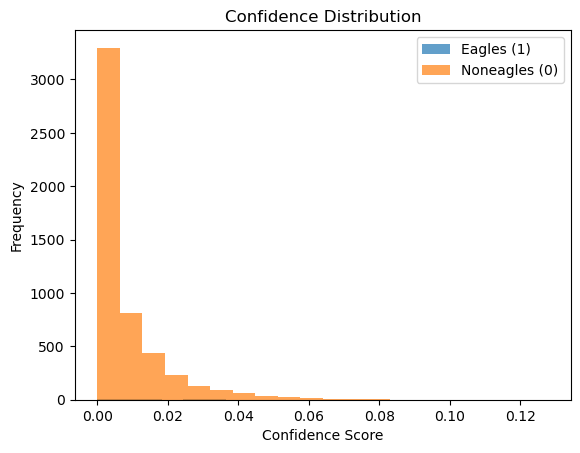

In [71]:
import matplotlib.pyplot as plt

plt.hist(eagle_confidence, bins=20, alpha=0.7, label='Eagles (1)')
plt.hist(noneagle_confidence, bins=20, alpha=0.7, label='Noneagles (0)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.legend()
plt.show()


In [36]:
# Get indices of ambiguous samples
ambiguous_indices = np.where((preds > 0.4) & (preds < 0.6))[0]

# Inspect some ambiguous samples (requires image visualization logic)
for idx in ambiguous_indices[:10]:  # First 10 ambiguous cases
    print(f"Sample {idx}: Label={label_train[idx]}, Confidence={preds[idx]:.4f}")
    # Add your image visualization code here if needed


Sample 0: Label=0, Confidence=0.4747
Sample 1: Label=1, Confidence=0.5125
Sample 2: Label=1, Confidence=0.5125
Sample 3: Label=1, Confidence=0.5125
Sample 4: Label=1, Confidence=0.5125
Sample 5: Label=1, Confidence=0.5125
Sample 6: Label=1, Confidence=0.5125
Sample 7: Label=0, Confidence=0.4747
Sample 8: Label=1, Confidence=0.5125
Sample 9: Label=1, Confidence=0.5125
